In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import pickle
import os
from PIL import Image
import re
import random
import shutil
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.models import vgg16
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import glob
import re
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler
from skimage.metrics import structural_similarity as ssim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
path = '/content/drive/MyDrive/DL_ASSIGN_04/Dataset_BUSI_with_GT'

In [5]:
class Image_Dataset(Dataset):
      def __init__(self,root_dir,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.mask_paths , self.labels = self.data_path()

      def __len__(self):
        return len(self.mask_paths)

      def __getitem__(self,idx):
        image = self.image_paths[idx]
        mask = self.mask_paths[idx]
        image = Image.open(image).convert("L")
        mask = Image.open(mask).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        label = self.labels[idx]
        return image , mask ,label

      def data_path(self):
        l = ['normal','malignant','benign']
        image_paths = []
        mask_paths = []
        labels = []
        for root, dirs, files in os.walk(path):

          for file in files:
              mask = os.path.join(root, file)
              if 'mask' in mask:
                mask_paths.append(mask)
                # print(mask)
                x = re.split("\s", mask,1)
                image = x[0] +' ' +(x[1].replace("_mask", ""))
                image_paths.append(image)
                # print(image)
        for i in image_paths:
          for index, element in enumerate(l):
            if element in mask:
              labels.append(index)
        return image_paths , mask_paths , labels



In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [7]:
batch_size = 32

In [8]:
dataset = Image_Dataset(root_dir=path, transform=transform)

In [9]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [10]:
train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle= True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer_1 = nn.Sequential( nn.Conv2d(1, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(64, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_2 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_3 = nn.Sequential( nn.Conv2d(128, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(256, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_4 = nn.Sequential( nn.Conv2d(256, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(512, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_5 = nn.Sequential( nn.Conv2d(512, 1024, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(1024, 1024, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))

        #Decoder
        self.up_conv_1 = nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2)
        self.layer_6 = nn.Sequential(
                       nn.Conv2d(1024, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(512, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.up_conv_2 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.layer_7 = nn.Sequential(
                       nn.Conv2d(512, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(256, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.up_conv_3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.layer_8 = nn.Sequential(
                       nn.Conv2d(256, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.up_conv_4 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.layer_9 = nn.Sequential(
                       nn.Conv2d(128, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(64, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_10 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.layer_1(x)  #...
        print(x1.size())
        x2 = self.max_pool(x1)
        print(x2.size())
        x3 = self.layer_2(x2) #...
        print(x3.size())
        x4 = self.max_pool(x3)
        print(x4.size())
        x5 = self.layer_3(x4) #...
        print(x5.size())
        x6 = self.max_pool(x5)
        print(x6.size())
        x7 = self.layer_4(x6) #...
        print(x7.size())
        x8 = self.max_pool(x7)
        print(x8.size())
        x9 = self.layer_5(x8)
        print(x9.size())

        #Decoder

        x10 = self.up_conv_1(x9)
        print(x10.size())
        x11 = self.layer_6(x10)
        print(x11.size())

        x12 = self.up_conv_2(x11)
        print(x12.size())
        x13 = self.layer_7(x12)
        print(x13.size())

        x14 = self.up_conv_3(x13)
        print(x14.size())
        x15 = self.layer_8(x14)
        print(x15.size())

        x16 = self.up_conv_4(x15)
        print(x16.size())
        x17 = self.layer_9(x16)
        print(x17.size())

        x18 = self.layer_10(x17)
        print(x18.size())
        return x18


if __name__ == "__main__":
    model = UNet()
    image = torch.rand(1, 1, 256, 256)

    print(model(image))

torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 32, 32])


RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[1, 512, 32, 32] to have 1024 channels, but got 512 channels instead

In [37]:
def  test_dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    y_true_flat_numpy = y_true_flat.numpy().tolist()
    y_pred_flat_numpy = y_pred_flat.numpy().tolist()

    intersection = np.sum(np.array(y_true_flat_numpy) * np.array(y_pred_flat_numpy))
    union = np.sum(np.array(y_true_flat_numpy)) + np.sum(np.array(y_pred_flat_numpy))

    dice = 1-((2. * intersection + smooth) / (union + smooth))
    return dice
def test_dice_score(y_true, y_pred, smooth=1e-6):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    y_true_flat_numpy = y_true_flat.numpy().tolist()
    y_pred_flat_numpy = y_pred_flat.numpy().tolist()

    intersection = np.sum(np.array(y_true_flat_numpy) * np.array(y_pred_flat_numpy))
    union = np.sum(np.array(y_true_flat_numpy)) + np.sum(np.array(y_pred_flat_numpy))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
patience = 3

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [38]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return dice

In [39]:
num_epochs = 5

In [40]:
training_loss = []
validation_loss = []
training_dice_scores = []
validation_dice_scores = []
train_acc = []
val_acc = []
best_metric_value = float('-inf')
best_model_weights = None
for epoch in range(num_epochs):
    train_true = []
    train_pred = []
    val_true = []
    val_pred = []
    model.train()
    training_running_loss = 0.0
    val_running_loss = 0.0
    dice_train_running = 0.0
    dice_val_running = 0.0
    for images, masks, class_ in train_loader:
        images = images
        masks = masks

        optimizer.zero_grad()
        outputs = model(images)

        loss = dice_loss(masks,outputs)
        dice = dice_score(masks,outputs)
        loss.backward()
        optimizer.step()

        loss_train = loss.item()
        dice_train = dice.item()
        train_loss = training_running_loss + loss_train
        train_dice_score = dice_train_running + dice_train

        for i in range(len(images)):
          image_true = masks[i:i+1]
          image_pred = outputs[i:i+1]

          y_true_flat = image_true.view(-1)
          y_true_flat_numpy = y_true_flat.numpy().tolist()
          y_pred_flat = image_pred.view(-1)
          y_pred_flat_numpy = y_pred_flat.detach().numpy().tolist()
          train_pred.append(y_pred_flat_numpy)
          train_true.append(y_true_flat_numpy)
          print(len(train_true),len(train_pred))


    print(train_true[:400])
    print(train_pred[:400])

    average_train_loss = train_loss / len(train_loader)
    average_dice_score = train_dice_score /len(train_loader)
    training_loss.append(average_train_loss)
    training_dice_scores.append(average_dice_score)

    train_true_int = train_true.astype(int)
    train_pred_int = train_pred.astype(int)
    accuracy = accuracy_score(train_true_int, train_pred_int)
    train_acc.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}],  Train Loss: {average_train_loss:.4f}, Training Accuracy: {accuracy}')

    model.eval()
    with torch.no_grad():
      for images, masks, class_ in val_loader:
        images = images
        masks = masks

        optimizer.zero_grad()
        outputs = model(images)

        loss = dice_loss(masks,outputs)
        dice = dice_score(masks,outputs)
        loss_val = loss.item()
        dice_val = dice.item()
        val_loss = val_running_loss + loss_val
        val_dice_score = dice_val_running + dice_val

        for i in range(len(images)):
          image_true = masks[i:i+1]
          image_pred = outputs[i:i+1]

          y_true_flat = image_true.view(-1)
          y_true_flat_numpy = y_true_flat.numpy().tolist()
          y_pred_flat = image_pred.view(-1)
          y_pred_flat_numpy = y_pred_flat.detach().numpy().tolist()
          val_pred.append(y_pred_flat_numpy)
          val_true.append(y_true_flat_numpy)


      average_val_loss = val_loss/len(val_loader)
      average_val_dice_score = val_dice_score /len(val_loader)
      validation_loss.append(average_val_loss)
      validation_dice_scores.append(average_val_dice_score)




      scheduler.step(average_val_loss)

        # Early stopping check
      if average_val_loss < best_val_loss and average_train_loss < best_val_loss:
            best_val_loss = average_val_loss
            epoch = 0

      else:
          epoch += 1
          if epoch >= patience:
              print(f'Validation loss has not improved for {patience} consecutive epochs. Early stopping...')
      # Best Weigts
      if average_val_dice_score > best_metric_value and average_val_dice_score > 0.6:
        best_metric_value = average_val_dice_score
        best_model_weights = model.state_dict()
        best_model = model()
        torch.save(best_model_weights, 'best_model_weights.pth')
        torch.save(best_model, 'best_model.pth')\


    val_true_int = val_true.astype(int)
    val_pred_int = val_pred.astype(int)
    accuracy = accuracy_score(val_true_int, val_pred_int)
    val_acc.append(accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}],  Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {accuracy}')



x_axis = [i for i in range(len(training_loss))]
plt.plot(x_axis, training_loss, label='Train Loss')
plt.plot(x_axis, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

x_axis = [i for i in range(len(train_acc))]
plt.plot(x_axis, train_acc, label='Train Accuracy')
plt.plot(x_axis, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

x_axis = [i for i in range(len(training_dice_scores))]
plt.plot(x_axis, training_dice_scores, label='Train Loss')
plt.plot(x_axis, validation_dice_scores, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Scores')
plt.legend()
plt.title('Training and Validation Dice_Scores')
plt.show()


torch.Size([5, 64, 128, 128])
torch.Size([5, 64, 64, 64])
torch.Size([5, 128, 64, 64])
torch.Size([5, 128, 32, 32])
torch.Size([5, 256, 32, 32])
torch.Size([5, 256, 16, 16])
torch.Size([5, 512, 16, 16])
torch.Size([5, 512, 8, 8])
torch.Size([5, 1024, 8, 8])
torch.Size([5, 1024, 16, 16])
torch.Size([5, 512, 16, 16])
torch.Size([5, 512, 32, 32])
torch.Size([5, 256, 32, 32])
torch.Size([5, 256, 64, 64])
torch.Size([5, 128, 64, 64])
torch.Size([5, 128, 128, 128])
torch.Size([5, 64, 128, 128])
torch.Size([5, 1, 128, 128])
1 1
2 2
3 3
4 4
5 5
torch.Size([5, 64, 128, 128])
torch.Size([5, 64, 64, 64])
torch.Size([5, 128, 64, 64])
torch.Size([5, 128, 32, 32])
torch.Size([5, 256, 32, 32])
torch.Size([5, 256, 16, 16])
torch.Size([5, 512, 16, 16])
torch.Size([5, 512, 8, 8])
torch.Size([5, 1024, 8, 8])
torch.Size([5, 1024, 16, 16])
torch.Size([5, 512, 16, 16])
torch.Size([5, 512, 32, 32])
torch.Size([5, 256, 32, 32])
torch.Size([5, 256, 64, 64])
torch.Size([5, 128, 64, 64])
torch.Size([5, 128, 128,

KeyboardInterrupt: 

In [ ]:
test_true = []
test_pred = []
test_dice_score = []
test_running_loss = 0.0
test_dice_score_ = 0.0
model.eval()
with torch.no_grad():
  for images, masks, class_ in test_loader:
    images = images
    masks = masks
    optimizer.zero_grad()
    outputs = model(images)
    for i in range(len(images)):
      image_true = masks[i:i+1]
      image_pred = outputs[i:i+1]
      test_true.append(image_true)
      test_pred.append(image_pred)
      # Calculate Dice loss and score for this image
      loss = testdice_loss(image_true, image_pred).item()
      dice = testdice_score(image_true, image_pred).item()
      test_dice_score.append(dice)

      test_dice_score_ += dice
      test_running_loss +=loss
  average_test_loss = test_running_loss/len(test_loader)
  average_test_dice = test_dice_score_/len(test_loader)
#loop
for i in range(5):
  if test_dice_score[i] >= 0.6:
    print(f'The Dice Score of the image is {test_dice_score[i]:.4f}')
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(test_true[i])
    axs[0].set_title('Image')


    axs[1].imshow(test_pred[i])
    axs[1].set_title('Mask')


    plt.show()

  else:
    if test_dice_score[i] < 0.6:
      print(f'The Dice Score of the image is {test_dice_score[i]:.4f}')
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))


    axs[0].imshow(test_true[i])
    axs[0].set_title('Image')


    axs[1].imshow(test_pred[i])
    axs[1].set_title('Mask')

    # Show the figure
    plt.show()





In [ ]:
# TSNE

In [12]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()

        # Encoder
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer_1 = nn.Sequential( nn.Conv2d(1, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(64, 64, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_2 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 128, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_3 = nn.Sequential( nn.Conv2d(128, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(256, 256, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_4 = nn.Sequential( nn.Conv2d(256, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(512, 512, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))
        self.layer_5 = nn.Sequential( nn.Conv2d(512, 1024, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(1024, 1024, kernel_size=3,padding = 1),
                       nn.ReLU(inplace=True))


    def forward(self, x):
          # Encoder
            x1 = self.layer_1(x)  #...
            # print(x1.size())
            x2 = self.max_pool(x1)
            # print(x2.size())
            x3 = self.layer_2(x2) #...
            # print(x3.size())
            x4 = self.max_pool(x3)
            # print(x4.size())
            x5 = self.layer_3(x4) #...
            # print(x5.size())
            x6 = self.max_pool(x5)
            # print(x6.size())
            x7 = self.layer_4(x6) #...
            # print(x7.size())
            x8 = self.max_pool(x7)
            # print(x8.size())
            x9 = self.layer_5(x8)
            # print(x9.size())

            return x9
if __name__ == "__main__":
    model_encoder = encoder()
    image = torch.rand(1, 1, 256, 256)

    print(model_encoder(image))

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0021, 0.0037, 0.0041,  ..., 0.0040, 0.0041, 0.0051],
          [0.0031, 0.0039, 0.0036,  ..., 0.0037, 0.0033, 0.0040],
          [0.0025, 0.0028, 0.0030,  ..., 0

0
0
0
0
0
0
0
0
0
0


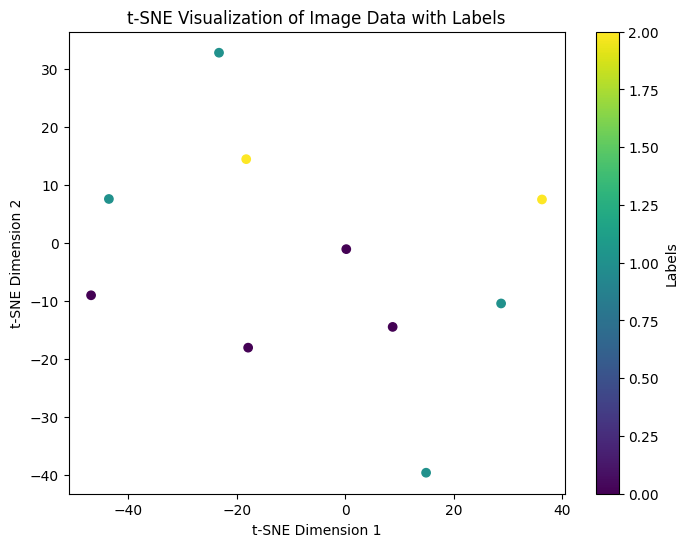

In [28]:
image_ = []
label_ = [0,1,2,1,2,0,1,0,1,0]
for i in range(10):  # Loop from 0 to 9 (inclusive) for the first 10 items
    image, label,class_= dataset[i]
    image_.append(image)

    # label_.append(class_)
images_np = np.array(image_)
labels_np = np.array(label_)
flattened_images = images_np.reshape(images_np.shape[0], -1)

tsne = TSNE(n_components=2, perplexity=5, random_state=0)
images = tsne.fit_transform(flattened_images)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(images[:, 0], images[:, 1], c=labels_np, cmap='viridis')
plt.colorbar(scatter, label='Labels')
plt.title('TSNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
